This notebook conducts a posterior predictive test for whether we can detect a non-GR theory of gravity using $E_G$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import fiducial as fid
import utils as u
import scipy.stats 
from scipy.stats import chi2
from scipy.stats import rv_histogram
from scipy.stats import binned_statistic
import specs as sp 

Define parameters etc.

In [2]:
# Parameters

lens = 'DESI'
src = 'LSSTY10'
Pimax=300.
rp0 = 1.5

# Number of E_G samples to draw:
#Nsamp = 1000

endfilename = 'post_pred_Jan15'

# Use the same cosmological parameters as Shadab's simulations:
h=0.69
OmB = 0.022/h**2

OmM = 0.292

# Using now nonliner bias parameters as fit in Kitanis & White 2022. 
# They fit LTP parameters so we convert these to their Eulerian equivalents.
b1_LPT = 1.333
b2_LPT = 0.514
bs_LPT = 0 # They fix this to 0.

# Convert to Eulerian using the conversions in Chen, Vlah & White 2020 (these use the same convention as Kitanis & White 2022)
b1 = 1.0 + b1_LPT
b2 = b2_LPT + 8./21.*(b1_LPT)
bs = bs_LPT - 2./7*(b1_LPT)

#b1 = 2.03
#b2 = 0.9*(b1-1.0)**2-0.5 # From Fast-PT example notebook which says 
#'(this is a numerical fit to simulation k2Pnl1_regdata, but a relationship of this form is motivated in the spherical collapse picture'
#bs = -4.0/7.0*(b1-1.0) # The 'coevolution value' see Pandey et al. DES Y3 papers
#Nsamps=100000

print('b1=', b1)
print('b2=', b2)
print('bs=', bs)

# A_s value is designed to match sigma8=0.82 in LCDM for other cosmological parameters. 
# We do this by manually finding the value of A_s that gives the right sigma8 using ccl_sigma8.

# Define Gaussian uncertainty for prior distribution on OmegaM0

# DES year 3 gives OmegaM0 = 0.339 + 0.032 - 0.031 for LCDM model. 
# Let's use roughly this error with our fiducial for the mean.
#OmMerr = 0.03

# Planck 2018 TT EE TE + lowE gives 0.3166 ± 0.0084, try this
OmMerr = 0.0084

# nDGP
Omega_rc = 0.5
h0rc = 1./np.sqrt(4*Omega_rc)
print('H0rc=', h0rc)

# f(R)
fr0 = 10**(-4)

params = {'mu_0': 0., 'sigma_0':0., 'OmB':OmB, 'h':h, 'n_s':0.965,'b':b1, 'OmM': OmM, 'b_2':b2, 'b_s': bs, 'fR0' : fr0, 'A_s':2.115 * 10**(-9), 'fR_n': 1, 'H0rc':h0rc} 

b1= 2.333
b2= 1.021809523809524
bs= -0.38085714285714284
H0rc= 0.7071067811865475


In [3]:
# Compute the mean redshift over the lenses, we need this later:

zvec, dNdz = sp.get_dNdzL(params, 'DESI')

zbar = scipy.integrate.simps(zvec*dNdz, zvec)
print('zbar=', zbar)

zbar= 0.7226958808077818


Load data covariance and rp bins stuff

In [4]:
# Scale cuts. 0 means cut the bin, 1 means keep it.
rp_c_scalecuts, scalecuts = np.loadtxt('../txtfiles/scalecuts_nLbias_CORRECTIONFACTOR_KitanidisWhite2022_LSSTY10.dat', unpack=True)

rp_bin_c_raw = np.loadtxt('../data_for_Danielle/test-HOD-PB00-z0.75-w1pz_cat-zRSD-model-5-gxm-sel-crossparticles-wtag-w1-rfact10-bin1-wp-logrp-pi-NJN-100.txt.upsilon')[:,0]
rp_bin_edges_raw = u.rp_bin_edges_log(rp_bin_c_raw)

#Cut below rp0 making sure rp0 is in the lowest bin. Go one bin lower because this 
ind = next(j[0] for j in enumerate(rp_bin_edges_raw) if j[1]>rp0)-1
rp_bin_c = rp_bin_c_raw[ind:]
rp_bin_edges = rp_bin_edges_raw[ind:]

#print('rp bin c=', rp_bin_c)
#print('rp bin edges=', rp_bin_edges)

# Covariance matrix:
# Notice this is the bias-correction version.
egcov = np.loadtxt('../txtfiles/cov_EG_nLbiascorrected_LSSTY10.dat')

covsamps = 100 # Number of simulations used to estimate covariance

hartlap = (covsamps-len(rp_bin_c)-2) / (covsamps-1)

inv_egcov = hartlap*np.linalg.inv(egcov)

In [5]:
# Begin loop over draws from data realisations.
# To get this working, first try just a small number of data realisations for quick debugging.
Nsamp=100

# Set up arrays and other stuff needed to store things over multiple data realisations

OmMsamp_datagen = np.zeros(Nsamp) # store the value sampled for OmM to generate the data
EG_fid_store = np.zeros((Nsamp, len(rp_bin_c))) # store the mean of the Gaussian used to generate the data
EG_data_store = np.zeros((Nsamp, len(rp_bin_c))) # store the sampled data realisation


# For the fit to constant model of the E_G data realisation:
vals = np.linspace(0.01,0.99,10000) # values at which we grid-sampl E_G constant model
loglike_vals = np.zeros((Nsamp, len(vals)))
like_vals = np.zeros((Nsamp, len(vals)))
like_vals_norm = np.zeros((Nsamp, len(vals)))
max_post_val = np.zeros(Nsamp) # best fit E_G constant model at a given realisation
chisq = np.zeros(Nsamp) # chisq of the best fit constant model with data realisation
cdf_samps = np.zeros(Nsamp)
const_bad_fit = np.zeros(Nsamp)

# For getting the posterior on OmegaM0 in the GR model:
OmMvals = np.linspace(0.1,0.5,10000) # values at which grid sample OmegaM0
logP_OmM = -0.5*(OmMvals - params['OmM'])**2/(OmMerr**2) # define DES Y3 LCDM prior
EGvals = fid.EG_theory(OmMvals, zbar) # Get corrsponding EG values
loglike_vals_OmM = np.zeros((Nsamp, len(OmMvals)))
like_vals_OmM = np.zeros((Nsamp, len(OmMvals)))
like_vals_norm_OmM = np.zeros((Nsamp, len(OmMvals)))

N_OmMfitsamp = 10000
OmMfitsamps_store = np.zeros((Nsamp, N_OmMfitsamp))
EG_rep_data_store = np.zeros((Nsamp, N_OmMfitsamp))


outside_95 = np.zeros(Nsamp)


for i in range(0, Nsamp):
    print('i=', i)

    #### GENERATE DATA REALISATION ####

    # Draw from OmegaM0 prior.
    OmMsamp = np.random.normal(params['OmM'], OmMerr, 1)
    print('OmMsamp=', OmMsamp)
    print('params OmM=', params['OmM'])
    OmMsamp_datagen[i] = OmMsamp

    # Using this value of OmegaM0, compute corresponding E_G 
    # (we assume this has been fully corrected for nonlinear
    # bias as we cannot compute the nonlinear bias correction
    # outside GR.

    # Compute E_G - alter final argument different gravity theory.
    EG_fid = fid.E_G(params, rp_bin_edges, rp0, lens, src, 
                 Pimax, endfilename, nonlin=False, MG=True, MGtheory='fR')
    EG_fid_store[i,:] = EG_fid

    # Using this as a mean with Eg_cov, draw a data realisation.
    EG_data = np.random.multivariate_normal(EG_fid, egcov, 1)
    EG_data_store[i,:] = EG_data

    #### FIT CONSTANT TO DATA REALISATION DRAW ####

    # Sample the likelihood. It's only a one dimensional parameter space so we can just grid-sample.

    for j in range(0,len(vals)):
        loglike_vals[i,j] = u.logL(vals[j]*np.ones(len(EG_data[0,:])), EG_data[0,:], inv_egcov)
        like_vals[i,j] = np.exp(loglike_vals[i,j])
        like_vals_norm[i,:] = like_vals[i,:]/ scipy.integrate.simps(like_vals[i,:], vals)

    # Get the maximum of the posterior point of the fit to the constant, 
    max_post_ind = np.argmax(like_vals_norm[i,:])
    max_post_val[i] = vals[max_post_ind]

    # Get the chi^2
    chisq[i] = np.dot((max_post_val[i] - EG_data[0,:]), 
                          np.dot(inv_egcov, (max_post_val[i] - EG_data[0,:])))
    
    # We want to look at a chi squared distribution with the correct number 
    # of degrees of freedom

    # Define the number of degrees of freedom:
    len_cut_dvec = len(EG_data[0,:])
    model_par = 1 # 1 parameter for a constant model
    DOF = len_cut_dvec - model_par

    # What we want is the CDF value at the chi square.
    # What this tells us is the probability that, given our constant model 
    # is correct, we would have got the chi square we got or a lower chi squared (fixing our measured data vector and cov).
    # Eg if CDF = 0.95, this means that if our model is correct, 95% of the time the chi squared would have been lower.
    # If we care about the model and the data agreeing within 1 sigma, we look for the case where CDF=0.68 or less
    # i.e. the case where if our model is correct, 68% of the time we would have drawn a lower chi-squared. 
    cdf_samps[i] = chi2.cdf(chisq[i], DOF)

    # Set to 1 where the cdf>=0.95 (corresponds to p value 0.05)
    if cdf_samps[i]>=0.95:
        const_bad_fit[i] = 1
        print('bad fit to constant, sample=', i)
        continue # No point in continuing in this case, we already know we reject GR
    print('this indicates we got past the bad fit to constant check in this iteration')
    #### GET POSTERIOR IN OMEGA_M_0_FIT IN GR MODEL ####

    for j in range(0,len(OmMvals)):
        loglike_vals_OmM[i,j] = u.logL(EGvals[j], EG_data[0,:], inv_egcov)
        #like_vals_OmM[i,j] = np.exp(loglike_vals_OmM[i,j])
        like_vals_OmM[i,j] = np.exp(loglike_vals_OmM[i,j] + logP_OmM[j]) # This version adds a prior.
    like_vals_norm_OmM[i,:] = like_vals_OmM[i,:]/ scipy.integrate.simps(like_vals_OmM[i,:], OmMvals)

    # Define a pdf on OmM from posterior values computed above.
    bin_means, bin_edges, bin_number = binned_statistic(OmMvals, like_vals_norm_OmM[i], statistic ='mean',bins=200)
    hist_OmM = bin_means, bin_edges
    OmMfit_dist = rv_histogram(hist_OmM, density = True) # can set density=True because normalised values.

    #### GET REPLICATED E_G DATA UNDER GR MODEL ####

    # Sample values from this distribution
    OmMfitsamps = OmMfit_dist.rvs(size=N_OmMfitsamp)

    OmMfitsamps_store[i,:] = OmMfitsamps

    # Get corresponding GR theory E_G values:
    EG_rep_data = fid.EG_theory(OmMfitsamps, zbar)
    EG_rep_data_store[i,:] = EG_rep_data

    # Get distribution of GR value for E_G.

    EG_rep_hist = np.histogram(EG_rep_data, bins = 50, density=True)
    EG_rep_dist = rv_histogram(EG_rep_hist, density=True)

    # Get the 5% and 95% confidence points of the distribution 

    ninetyfive_intervals_EGrep = EG_rep_dist.interval(0.95)

    # Does the constant best fit value to the original data fall
    # outside the 95%?

    if max_post_val[i] <= ninetyfive_intervals_EGrep[0] or max_post_val[i]>= ninetyfive_intervals_EGrep[1]:
        outside_95[i] = 1    

i= 0
OmMsamp= [0.27870352]
params OmM= 0.292
getting Upgg
getting Upgm
maxchi= 6669.353003473356
this indicates we got past the bad fit to constant check in this iteration
i= 1
OmMsamp= [0.2931039]
params OmM= 0.292
getting Upgg
getting Upgm
maxchi= 6669.353003473356
this indicates we got past the bad fit to constant check in this iteration
i= 2
OmMsamp= [0.28275731]
params OmM= 0.292
getting Upgg
getting Upgm
maxchi= 6669.353003473356
this indicates we got past the bad fit to constant check in this iteration
i= 3
OmMsamp= [0.29456308]
params OmM= 0.292
getting Upgg
getting Upgm
maxchi= 6669.353003473356
this indicates we got past the bad fit to constant check in this iteration
i= 4
OmMsamp= [0.30944273]
params OmM= 0.292
getting Upgg
getting Upgm
maxchi= 6669.353003473356
bad fit to constant, sample= 4
i= 5
OmMsamp= [0.29614158]
params OmM= 0.292
getting Upgg
getting Upgm
maxchi= 6669.353003473356
this indicates we got past the bad fit to constant check in this iteration
i= 6
OmMsamp=

In [6]:
num_bad_fit = np.sum(const_bad_fit)
num_outside_95 = np.sum(outside_95)

total_reject = num_bad_fit + num_outside_95

frac_reject = total_reject / Nsamp

print('we reject GR ', total_reject, ' times out of ', Nsamp,' so fractional reject rate is ', frac_reject)
print(num_bad_fit, ' are rejected due to fit to constant and ', num_outside_95, ' are rejected due to posterior predictive')

we reject GR  99.0  times out of  100  so fractional reject rate is  0.99
1.0  are rejected due to fit to constant and  98.0  are rejected due to posterior predictive


In [7]:
# Save files that we might want to look at later:
savedir = '/home/campus.ncl.ac.uk/ncl117/Research/EG_comparison/txtfiles/posterior_predictive/LSSTY10/OmM0prior_Planck2018/fR4/'
#savedir = '/home/danielle/Research/EG_comparison/txtfiles/posterior_predictive/OmM0prior_Planck2018/fR6/'


In [9]:

np.savetxt(savedir+'/OmMsamp_datagen.dat', OmMsamp_datagen, header='index = data realisation samples') # store the value sampled for OmM to generate the data
np.savetxt(savedir+'/EG_fid.dat', EG_fid_store, header='rows = data realisation samples, cols = rp bins') # store the mean of the Gaussian used to generate the data
np.savetxt(savedir+'/EG_data_real.dat',EG_data_store, header='rows = data realisation samples, cols = rp bins') # store the sampled data realisation

np.savetxt(savedir+'/likevals_norm_constEG.dat', like_vals_norm, header='rows= data realisation samples, cols = values of grid sampling in EG, 0.01 to 0.99, 10000 samples')
np.savetxt(savedir+'/constEG_bestfits.dat', max_post_val, header = 'index = data realisation samples') # best fit E_G constant model at a given realisation

np.savetxt(savedir+'/likevals_norm_OmMfit.dat', like_vals_norm_OmM, header = 'rows = data realisation samples, cols = values of grid sampling in OmM, 0.1 to 0.5, 10000 points')

np.savetxt(savedir+'/OmMfit_samples.dat', OmMfitsamps_store, header = 'rows = data realisation, cols = samples from likelihood, unordered')
np.savetxt(savedir+'/EG_rep_data.dat', EG_rep_data_store, header = 'rows = data realisation, cols = corresponds to OmM samples from likelihood in OmMfit_samples.dat')

np.savetxt(savedir+'/const_bad_fit.dat', const_bad_fit, header = 'index = data realisation, 1 means it is a bad fit to a constant model')
np.savetxt(savedir+'/outside_95.dat', outside_95, header = 'index = data realisation, 1 means the data falls outside 95 pc of post predictive')


Load the stuff to look at:

In [65]:
#OmMsamp_datagen = np.loadtxt(savedir+'/OmMsamp_datagen.dat') # the value sampled for OmM to generate the data
EG_fid_datagen = np.loadtxt(savedir+'/EG_fid.dat') # rows = data realisation samples, cols = rp bins
EG_real_datagen = np.loadtxt(savedir+'/EG_data_real.dat') # rows = data realisation samples, cols = rp bins

like_constEG = np.loadtxt(savedir+'/likevals_norm_constEG.dat') # rows= data realisation samples, cols = values of grid sampling in EG, 0.01 to 0.99, 10000 samples
maxpost_constEG = np.loadtxt(savedir+'/constEG_bestfits.dat') # best fit E_G constant model at a given realisation, index = data realisation samples

like_OmMfit = np.loadtxt(savedir+'/likevals_norm_OmMfit.dat') # rows = data realisation samples, cols = values of grid sampling in OmM, 0.1 to 0.5, 10000 points

OmMsamp_fit = np.loadtxt(savedir+'/OmMfit_samples.dat') # rows = data realisation, cols = samples from likelihood, unordered
EG_rep = np.loadtxt(savedir+'/EG_rep_data.dat') # rows = data realisation, cols = corresponds to OmM samples from likelihood in OmMfit_samples.dat

const_bad_fit = np.loadtxt(savedir+'/const_bad_fit.dat') #index = data realisation, 1 means it is a bad fit to a constant model
outside95 = np.loadtxt(savedir+'/outside_95.dat') #index = data realisation, 1 means the data falls outside 95 pc of post predictive

Reconstruct the accept / reject ratio from the saved files

In [66]:
Nsamp = len(const_bad_fit)
num_bad_fit = np.sum(const_bad_fit)
num_outside_95 = np.sum(outside95)

total_reject = num_bad_fit + num_outside_95

frac_reject = total_reject / Nsamp

print('we reject GR ', total_reject, ' times out of ', Nsamp,' so fractional reject rate is ', frac_reject)
print(num_bad_fit, ' are rejected due to fit to constant and ', num_outside_95, ' are rejected due to posterior predictive')

we reject GR  7.0  times out of  100  so fractional reject rate is  0.07
7.0  are rejected due to fit to constant and  0.0  are rejected due to posterior predictive


In [13]:
# Set a realisation index to visualise
real = 4

print('Data-generating OmM0 = ', OmMsamp_datagen[real])
print('Associated mean E_G in MG = ', EG_fid_datagen[real,:])
print('And E_G including data-generating noise = ', EG_real_datagen[real,:])
print('GR theory E_G for data-generating OmM0 = ', fid.EG_theory(OmMsamp_datagen[real], zbar))
print('Best fit constant E_G values = ', maxpost_constEG[real])

# Get the max likelihood OmM_fit 
OmMvals = np.linspace(0.1,0.5,10000) # values at which grid sample OmegaM0
max_post_ind_OmM = np.argmax(like_OmMfit[real,:])
max_post_val_OmM = OmMvals[max_post_ind_OmM]
print('Max like OmM_fit = ', max_post_val_OmM)
print('Corresponding max EG_rep=', fid.EG_theory(max_post_val_OmM, zbar))

# Reconstruct the 95% values
EG_rep_hist = np.histogram(EG_rep[real,:], bins = 50, density=True)
EG_rep_dist = rv_histogram(EG_rep_hist, density=True)
# Get the 5% and 95% confidence points of the distribution 
ninetyfive_intervals_EGrep = EG_rep_dist.interval(0.95)
print('95 percent intervals for E_G rep=', ninetyfive_intervals_EGrep)


Data-generating OmM0 =  0.284534420845803
Associated mean E_G in MG =  [0.34689238 0.3468949  0.34689237 0.34689122 0.34689002 0.34688844 0.34688624 0.34688305 0.34687844 0.34687178 0.34686216 0.34684826 0.34682797 0.34679703 0.34674385 0.34662617]
And E_G including data-generating noise =  [0.30474715 0.29190876 0.37169762 0.35503069 0.35640394 0.35702601 0.35611744 0.35360172 0.36141519 0.35470955 0.35796272 0.35606392 0.35676226 0.35599284 0.34355128 0.34183405]
GR theory E_G for data-generating OmM0 =  0.3545543490101882
Best fit constant E_G values =  0.34244924492449247
Max like OmM_fit =  0.27589758975897594
Corresponding max EG_rep= 0.3465109241281304
95 percent intervals for E_G rep= (0.3206669859050988, 0.3714080886739909)


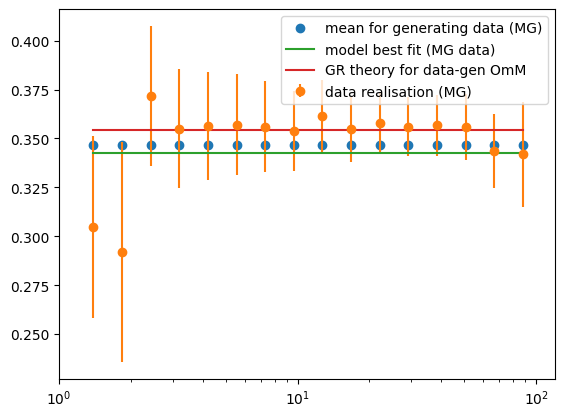

In [14]:
plt.figure()
plt.semilogx(rp_bin_c, EG_fid_datagen[real,:], 'o', label='mean for generating data (MG)')
plt.errorbar(rp_bin_c, EG_real_datagen[real,:],yerr = np.sqrt(np.diag(egcov)), marker='o', linestyle='', label= 'data realisation (MG)')
plt.semilogx(rp_bin_c, maxpost_constEG[real]*np.ones(len(rp_bin_c)), label='model best fit (MG data)')
plt.semilogx(rp_bin_c, fid.EG_theory(OmMsamp_datagen[real], zbar)*np.ones(len(rp_bin_c)), label='GR theory for data-gen OmM' )
plt.xlim(1,120)
plt.legend()
plt.show()

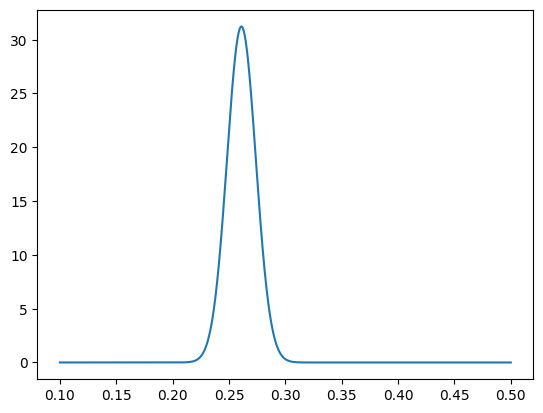

In [20]:
plt.figure()
plt.plot(OmMvals, like_OmMfit[real,:])
plt.show()

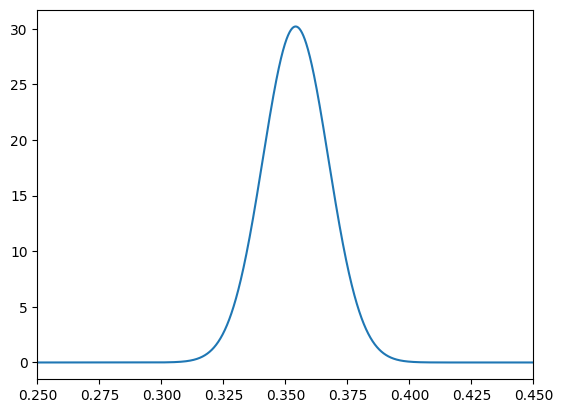

In [15]:
plt.figure()
plt.plot(vals, like_constEG[real,:])
plt.xlim(0.25,0.45)
plt.show()

In [12]:
# Get the chi^2
chisq= np.dot((maxpost_constEG[real] - EG_real_datagen[real,:]), 
                          np.dot(inv_egcov, (maxpost_constEG[real] - EG_real_datagen[real,:])))


In [13]:

# We want to look at a chi squared distribution with the correct number 
# of degrees of freedom

# Define the number of degrees of freedom:
len_cut_dvec = len(EG_fid_datagen[real,:])
model_par = 1 # 1 parameter for a constant model
DOF = len_cut_dvec - model_par
print('DOF=', DOF)
# Even though the data is correlated, this should be okay in terms of an estimate of DOF from data points.
# Think about the fact that in the linear regime, if we Fourier transform, we know that wavenumbers are independent.
# Also consider doing an SVD on the data covariance and rotating to decoupling the data points from each other.

chisq_vec = np.linspace(0,40,100)

cdf_dist = chi2.cdf(chisq_vec, DOF)

cdf_at_chisq = chi2.cdf(chisq, DOF)
print('CDF at my chisq=', cdf_at_chisq)
# The correct check if whether this is greater than or equal to 0.95
# We don't need to worry about the low-chisq tail - if we fall there, it means we have a great fit but it's probably overfitting.
# But this means the model is still good.

#plt.figure()
#plt.plot(chisq_vec, cdf_dist)
#plt.show()

DOF= 15
CDF at my chisq= 0.28044592591833334


In [ ]:
# What is the best-fit value of OmM0 under the GR model? Interesting to compare this with data-generating OmM0?